# In which we use the [WayBack Machine](https://archive.org/web/) to scrape historical data on the number of signatures for the [Petition to Revoke Article 50](https://petition.parliament.uk/petitions/241584).

## Once this notebook has loaded properly, select "Kernel" then "Restart & Run All" to get the latest data.

## (This script doesn't touch the [UK Parliament Petitions Site](https://petition.parliament.uk/) in any way.)


In [1]:
from datetime import datetime
from functools import partial
import json
from multiprocessing import Pool
import string

from bs4 import BeautifulSoup
import ipywidgets as widgets
from ipywidgets import Layout
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import requests
from scipy.optimize import curve_fit

## Rather helpfully, the WayBack Machine has an [API](https://github.com/internetarchive/wayback/tree/master/wayback-cdx-server)...

In [2]:
def get_timestamps(url):
    req = requests.get('http://web.archive.org/cdx/search/cdx',
        params={'url': url, 'output': 'json'})
    return sorted(set([item[1] for item in req.json()[1:]]))

def extract_count(url,timestamp):
    req = requests.get('http://web.archive.org/web/{}/{}'.format(timestamp, url))
    soup = BeautifulSoup(req.content)
    return int(''.join(filter(lambda c: c in string.digits,
        soup.find('span', class_='count').text)))

def get_counts(url):
    timestamps = get_timestamps(url)
    scrape_pool = Pool()
    counts = scrape_pool.starmap(extract_count, ((url, t) for t in timestamps))
    times = map(lambda t: datetime.strptime(t, '%Y%m%d%H%M%S'), timestamps)
    return list(times), list(counts)

def get_title(url, timestamp):
    req = requests.get('http://web.archive.org/web/{}/{}'.format(timestamp, url))
    soup = BeautifulSoup(req.content)
    return soup.find('h1').contents[-1].strip()
    

## Fit the number of signatures $s$ at time $t$:
$$\Large s(t) = a - be^{-ct}$$

$$\Large t(s) = -\frac{\ln(\frac{a-s}{b})}{c} $$

## where $t$ is relative to the the 0th timestamp.

In [3]:
def shifted_timestamps(times):
    t0 = times[0].timestamp()
    ts = np.array([t.timestamp() for t in times]) - t0
    
    return t0, ts

def fit(t, a, b, c):
    return a - b*np.exp(-c*t)

def inv_fit(count, t0, a, b ,c):
    return datetime.fromtimestamp(int(abs(np.log((a-count)/b)/-c)) + t0)

def get_fit(ts, counts):
    pars, _ = curve_fit(fit, ts[1:], counts[1:], p0=(counts[-1], counts[1], 1/ts[-1]))
    a, b, c = pars
    fitter = partial(fit, a=a, b=b, c=c)
    inv_fitter = partial(inv_fit, a=a, b=b, c=c)
    return fitter, inv_fitter

In [4]:
def plot_signatures(title, times, counts, fitted=None):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %H:%M'))
    plt.gcf().autofmt_xdate()
    plt.xlabel('time', fontsize=20)
    plt.ylabel('signatures', fontsize=20)
    plt.title(title, fontsize=16)
    plt.plot(times,counts,  marker='o')
    if not fitted is None:
        fit_index = np.ravel(np.argwhere(fitted > 0))[0]
        plt.plot(times[fit_index:] ,fitted[fit_index:])    
    plt.show()

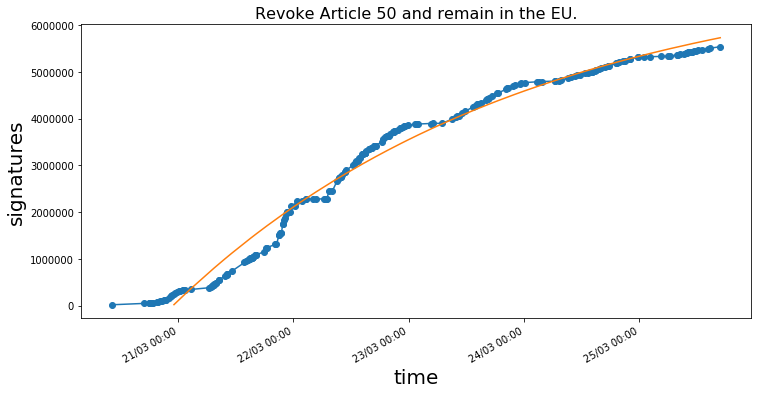

In [5]:
revoke_art_50 = 'https://petition.parliament.uk/petitions/241584'
times, counts = get_counts(revoke_art_50)
title = get_title(revoke_art_50, times[0])
t0, ts = shifted_timestamps(times)
fitter, inv_fitter = get_fit(ts, counts)
plot_signatures(title, times, counts, np.array(list(map(fitter, ts))))

In [6]:
rightnow = datetime.now()
print('Predicted {} signatures at {}.'.format(
    int(fitter(rightnow.timestamp()-t0)), rightnow.isoformat()))

Predicted 5734090 signatures at 2019-03-25T17:14:12.600354.


## Have some JSON data to copy and paste:

In [7]:
print(json.dumps(list(zip(map(lambda t: t.isoformat(),times),counts))))

[["2019-03-20T10:05:23", 18743], ["2019-03-20T16:46:28", 47774], ["2019-03-20T17:48:42", 56059], ["2019-03-20T18:06:19", 59201], ["2019-03-20T18:06:59", 59317], ["2019-03-20T18:27:34", 62991], ["2019-03-20T18:47:37", 66933], ["2019-03-20T19:28:41", 78087], ["2019-03-20T19:47:33", 83825], ["2019-03-20T20:07:36", 90300], ["2019-03-20T20:35:32", 100810], ["2019-03-20T21:07:06", 115783], ["2019-03-20T21:08:23", 116492], ["2019-03-20T21:27:18", 127255], ["2019-03-20T22:07:13", 171850], ["2019-03-20T22:26:17", 198107], ["2019-03-20T22:29:15", 202071], ["2019-03-20T22:45:38", 223736], ["2019-03-20T23:06:04", 250418], ["2019-03-20T23:24:49", 271077], ["2019-03-20T23:43:10", 289607], ["2019-03-21T00:03:49", 306097], ["2019-03-21T00:22:29", 317280], ["2019-03-21T00:53:45", 329744], ["2019-03-21T01:01:49", 332079], ["2019-03-21T01:21:56", 336529], ["2019-03-21T02:44:55", 347605], ["2019-03-21T06:23:14", 383006], ["2019-03-21T06:43:11", 398567], ["2019-03-21T07:01:06", 417401], ["2019-03-21T07:05:

## Try it with any [UK Parliament Petition](https://petition.parliament.uk/) you like...

# There was also the [Petition to Rescind Article 50 if Vote Leave Broke the Law](https://petition.parliament.uk/petitions/223729).

## (~100K signatures were reached at 2100 18/07/18, we only get data points when the WayBack Machine takes a snapshot.)

## Spoilers: People get really into it when it becomes brutally obvious that [Vote Leave did break the law](https://www.theguardian.com/politics/2018/jul/17/vote-leave-broke-electoral-law-and-british-democracy-is-shaken).

## Paste the URL of the petition into the box and click the button.

In [8]:
%matplotlib inline

go_button = widgets.Button(description="Get Petition History")

leave_cheated = 'https://petition.parliament.uk/petitions/223729'

url_text = widgets.Text(
    value = leave_cheated,
    placeholder = 'petition URL',
    description = 'Petition URL',
    layout=Layout(width='75%'),
    hidden=False)

def on_button_clicked(button):
    url = url_text.value
    times, counts = get_counts(url)
    title = get_title(url, times[0])
    plot_signatures(title, times, counts)
    print(json.dumps(list(zip(map(lambda t: t.isoformat(),times),counts))))
    
go_button.on_click(on_button_clicked)
    
display(url_text)   
display(go_button)

Text(value='https://petition.parliament.uk/petitions/223729', description='Petition URL', layout=Layout(width=…

Button(description='Get Petition History', style=ButtonStyle())

## Consider the [Rejected Petitions Twitter account](https://twitter.com/rejectpetitions)...